<style>
    .titulo-violeta {
        color: #c485ff;
    }
</style>

<h1 class="titulo-violeta">TP Convolutional Neural Networks</h1>

## <span style="color:lightblue">Avanzado IA</span>

### <span style="color:lightblue">Tp hecho por Benjamin Kapustiansky, Gabriel Slotnisky, Lucas Bertoloni y Oliver Safdieh</span> 

## Problematica a resolver:
Un programa no podia diferenciar entre algunos tipos de frutas (apple, palta, banana, cereza y kiwi)

## Solución propuesta:
Mediante un modelo de CNN, nosotros logramos identificar y diferenciar estas frutas. Es una clasificación multiclase de una sola salida. En este caso, las clases son 5.

## <span style="color:lightblue">Libraries</span>

In [1]:
# Estas líneas de código nos permiten instalar opencv desde Jupyter Notebook, que vamos a necesitar para importar 'cv2'
import sys
!{sys.executable} -m pip install opencv-python --user


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
%pip install setuptools
%pip install distutils

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement distutils (from versions: none)
ERROR: No matching distribution found for distutils


In [40]:
%pip install matplotlib
%pip install numpy
%pip install tensorflow
%pip install pandas
%pip install scikit-learn
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization


print(tf.__version__)

2.18.0


In [3]:
import seaborn as sns

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import csv

from PIL import Image

import os
import shutil

import random
SEED = 456
random.seed(SEED)

In [4]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

## <span style="color:lightblue">Dataset</span>

### Introducción

El dataset lo armamos nosotros con imagenes extraidas de Kaggle. Estas imagenes estaban ya distribuidas en capertas distintas entre train y test y subdivididas en sus respectivas clases. Lo que nostros hicimos a mano, fue filtrar imagenes que no nos servian y ademas unificar estas imagenes por clase para luego nosotros decidir la proporcion a utilizar entre TRAIN, TEST y VALIDATION

Link al [Kaggle](https://www.kaggle.com/datasets/karimabdulnabi/fruit-classification10-class?select=MY_data)

### Armado del Dataset

Mover imagenes desde la carpeta original (Frutas) hacia la nueva creada por nosotros (Fruits)

In [5]:
# Definir las rutas de las carpetas
apple_paths = ["Frutas/apple", "Frutas/apple2"]
avocado_paths = ["Frutas/avocado", "Frutas/avocado2"]
banana_paths = ["Frutas/banana", "Frutas/banana2"]
cherry_paths = ["Frutas/cherry", "Frutas/cherry2"]
kiwi_paths = ["Frutas/kiwi", "Frutas/kiwi2"]

# Función para listar imágenes en carpetas
def list_images_in_paths(paths):
    images = []
    for path in paths:
        if os.path.exists(path):  # Verificar si la carpeta existe
            images.extend([os.path.join(path, file) for file in os.listdir(path) if file.endswith((".jpg", ".png", ".jpeg"))])
    return images

# Crear listas de imágenes divididas por clase
apple_images = list_images_in_paths(apple_paths)
avocado_images = list_images_in_paths(avocado_paths)
banana_images = list_images_in_paths(banana_paths)
cherry_images = list_images_in_paths(cherry_paths)
kiwi_images = list_images_in_paths(kiwi_paths)

# Ruta principal "fruits"
fruits_dir = "fruits"

# Crear carpeta principal si no existe
if not os.path.exists(fruits_dir):
    os.makedirs(fruits_dir)

# Función para mover las imágenes a las subcarpetas correspondientes
def move_images_to_fruit_folder(fruit_name, image_list):
    # Crear la subcarpeta de la fruta si no existe
    fruit_folder = os.path.join(fruits_dir, fruit_name)
    if not os.path.exists(fruit_folder):
        os.makedirs(fruit_folder)
    
    # Mover cada imagen a su carpeta correspondiente
    for image_path in image_list:
        if os.path.exists(image_path):
            # Obtener el nombre de la imagen
            image_name = os.path.basename(image_path)
            # Definir la ruta de destino
            destination = os.path.join(fruit_folder, image_name)
            # Mover la imagen
            shutil.move(image_path, destination)
            print(f"Moved {image_name} to {fruit_folder}")

# Mover las imágenes de cada clase a sus respectivas carpetas
move_images_to_fruit_folder("apple", apple_images)
move_images_to_fruit_folder("avocado", avocado_images)
move_images_to_fruit_folder("banana", banana_images)
move_images_to_fruit_folder("cherry", cherry_images)
move_images_to_fruit_folder("kiwi", kiwi_images)


Aca pasamos a crear el csv con las imagenes que estan en la carpeta Fruits

In [6]:
# Definir las listas de imágenes y sus etiquetas
classes = {
    0: "apple",
    1: "avocado",
    2: "banana",
    3: "cherry",
    4: "kiwi",
}

# Función para generar una lista de imágenes y etiquetas
def generate_image_label_list():
    image_label_list = []
    for label, fruit in classes.items():
        fruit_folder = os.path.join(fruits_dir, fruit)
        if os.path.exists(fruit_folder):
            # Listar todas las imágenes de la carpeta
            images = [os.path.join(fruit_folder, file) for file in os.listdir(fruit_folder) if file.endswith((".jpg", ".png", ".jpeg"))]
            # Añadir las imágenes con su etiqueta
            image_label_list.extend([[image, label] for image in images])
    return image_label_list

# Generar la lista de imágenes y etiquetas
image_label_list = generate_image_label_list()

# Crear el archivo CSV
csv_file_path = "fruits.csv"
with open(csv_file_path, mode="w", newline="", encoding="utf-8") as csv_file:
    writer = csv.writer(csv_file)
    # Escribir los encabezados
    writer.writerow(["Image", "Label"])
    # Escribir las filas (imagen, etiqueta)
    writer.writerows(image_label_list)

print(f"CSV file created successfully: {csv_file_path}")


CSV file created successfully: fruits.csv


### Import dataset

In [7]:
archivo = "fruits.csv"

# Leer datos del archivo
frutas : pd.DataFrame = pd.read_csv(archivo)
frutas

,Image,Label
0,fruits\apple\images.jpeg,0
1,fruits\apple\img_01.jpeg,0
2,fruits\apple\img_1001.jpeg,0
3,fruits\apple\img_101.jpeg,0
4,fruits\apple\img_1011.jpeg,0
...,...,...
1596,fruits\kiwi\img_931.jpeg,4
1597,fruits\kiwi\img_941.jpeg,4
1598,fruits\kiwi\img_961.jpeg,4
1599,fruits\kiwi\img_971.jpeg,4


### Plot 10 images

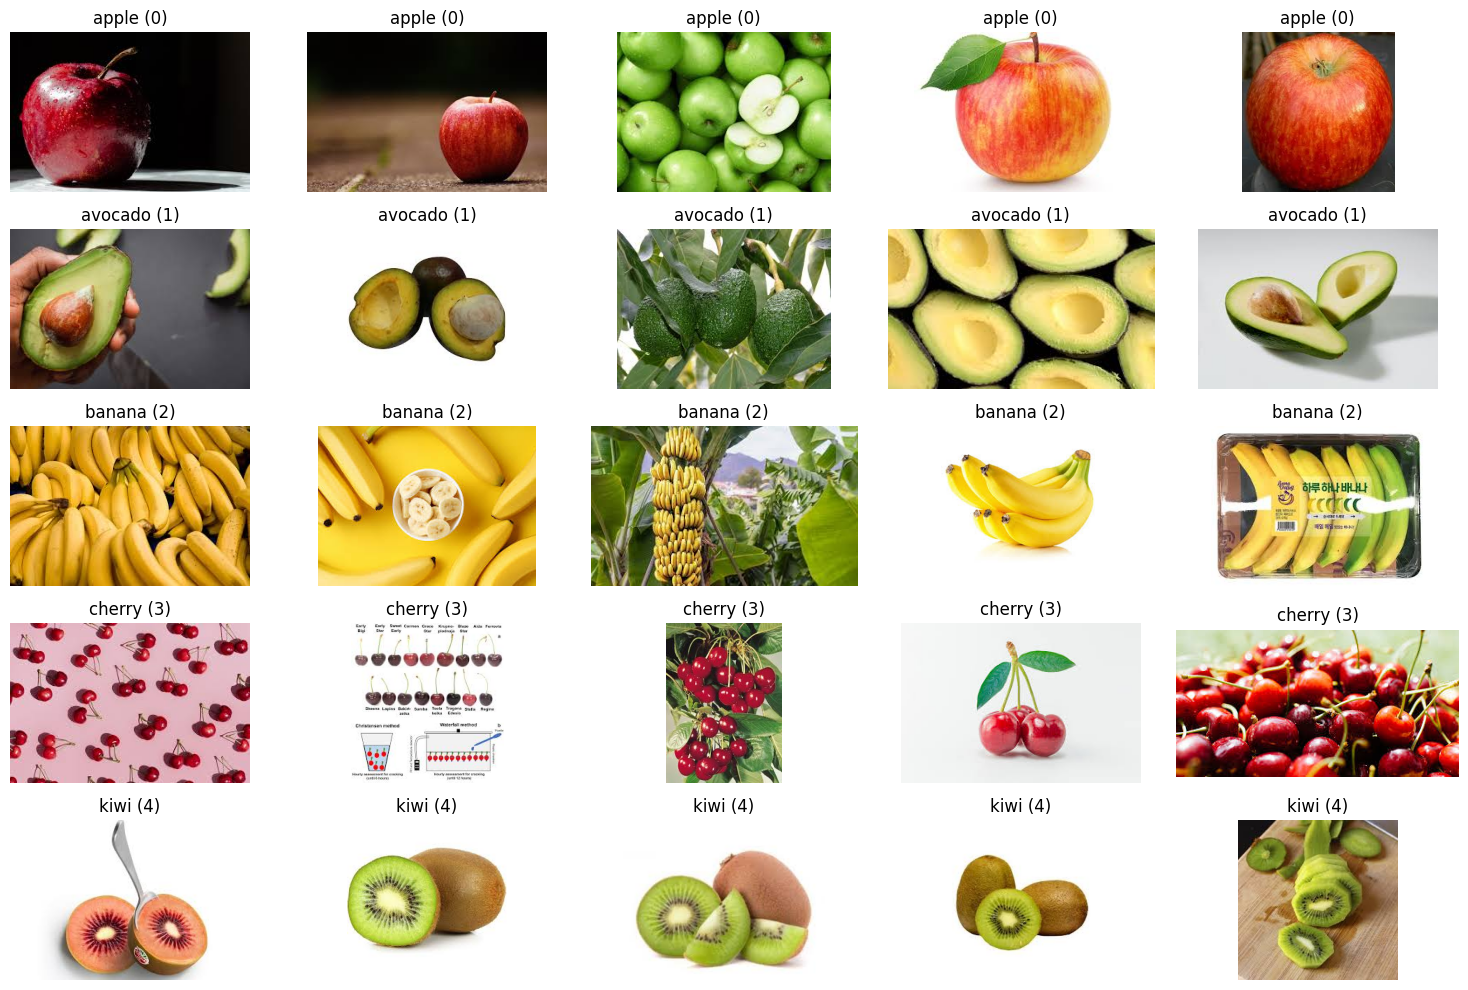

In [8]:
# Función para visualizar imágenes
def visualize_images_per_class(image_label_list, classes, images_per_class=5):
    # Crear una figura para mostrar imágenes
    num_classes = len(classes)
    plt.figure(figsize=(15, num_classes * 2))
    
    # Filtrar y mostrar imágenes por clase
    for class_label, class_name in classes.items():
        # Filtrar las imágenes de la clase actual
        class_images = [item for item in image_label_list if item[1] == class_label]
        selected_images = class_images[:images_per_class]  # Seleccionar las primeras `images_per_class`
        
        for i, (image_path, label) in enumerate(selected_images):
            # Subplot para cada imagen
            plt_index = i + 1 + class_label * images_per_class
            plt.subplot(num_classes, images_per_class, plt_index)
            
            # Abrir y mostrar la imagen
            if os.path.exists(image_path):
                image = Image.open(image_path)
                plt.imshow(image)
            plt.axis("off")  # Quitar ejes
            plt.title(f"{class_name} ({label})")
    
    plt.tight_layout()
    plt.show()

# Llamar a la función
visualize_images_per_class(image_label_list, classes, images_per_class=5)



### Dataset Split

#### Variables globales

In [33]:
batch_size = 32
data_dir = "fruits"
img_height = 224
img_width = 224

In [34]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int')
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int')
ds = tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      labels='inferred',
      color_mode='rgb',
      batch_size=32,
      image_size=(img_height, img_width),
      shuffle=True,
      seed=SEED,
      label_mode='int'
  )

Found 1601 files belonging to 5 classes.
Using 1281 files for training.
Found 1601 files belonging to 5 classes.
Using 320 files for validation.
Found 1601 files belonging to 5 classes.


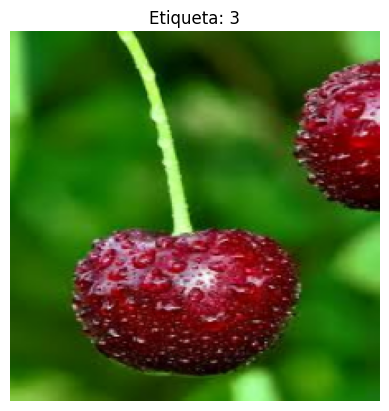

In [35]:
for batch_images, batch_labels in train_ds.take(1):  # Toma un batch (32 imágenes por defecto)
    image = batch_images[1]  # Extrae la segunda imagen del batch
    label = batch_labels[1]  # Extrae la segunda etiqueta del batch
    
    # Muestra la imagen
    plt.imshow(image.numpy().astype("uint8"))  # Convierte el tensor a imagen
    plt.title(f"Etiqueta: {label.numpy()}")
    plt.axis("off")
    plt.show()


In [36]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert train_split + val_split + test_split == 1.0
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=SEED)

        train_size = int(train_split * ds_size)
        val_size = int(val_split * ds_size)

        train_ds = ds.take(train_size)
        val_ds = ds.skip(train_size).take(val_size)
        test_ds = ds.skip(train_size + val_size)
    return train_ds, test_ds, val_ds
train_ds, test_ds, val_ds = get_dataset_partition_tf(ds, shuffle_size=10000, train_split = 0.6, val_split = 0.2, test_split = 0.2)

In [38]:
train_ds

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [47]:
# Listas para almacenar las características (X_test) y las etiquetas (y_test)
X_test = []
y_test = []

# Itera sobre el dataset de prueba
for features, labels in test_ds:
    X_test.append(features.numpy())  # Convertir los tensores a arrays de NumPy
    y_test.append(labels.numpy())

# Convertir las listas a arrays de NumPy
X_test = np.array(X_test)
y_test = np.array(y_test)

# <span style="color:gold">Sequential Model- Model 1</span>

## Creacion del modelo

In [54]:
# MODELO DE IA DEL PROYTECTO DE BENJO, MODIFICARLO A NUESTRO PROYECTO

num_classes = 5  # Para clasificación multiclase

# Define la capa de entrada explícitamente
inputs = tf.keras.Input(shape=(img_height, img_width, 3), name='input_layer')

# Define el modelo secuencial utilizando el input explícito
x = tf.keras.layers.Rescaling(1./255, name='res_layer_1')(inputs) #rescala
x = tf.keras.layers.Conv2D(8, 3, padding='same', name='conv_layer_1')(x) #primera capa convolucional
x = tf.keras.layers.Activation('relu', name='conv_layer_1_act')(x) #función de activación
x = tf.keras.layers.MaxPooling2D(name='max_pooling_layer_1')(x) #capa de pooling
x = tf.keras.layers.Conv2D(8, 3, padding='same', name='conv_layer_2')(x) #segunda capa convolucional
x = tf.keras.layers.Activation('relu', name='conv_layer_2_act')(x) #función de activación
x = tf.keras.layers.MaxPooling2D(name='max_pooling_layer_2')(x) #capa de pooling
x = tf.keras.layers.Flatten(name='flatten_layer_1')(x) #aplanar
x = tf.keras.layers.Dense(128, name='dense_layer_1', activation='relu')(x) #bias, weights, función de activación (relu)

# Salida final con activación sigmoid para clasificación binaria
outputs = tf.keras.layers.Dense(num_classes, name='output_layer', activation="softmax")(x) #nos devuleve 5 outputs

# Crea el modelo funcional
modelo = tf.keras.Model(inputs=inputs, outputs=outputs)

## Compilación del modelo

In [55]:
modelo.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [56]:
epoch = 15
history = modelo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epoch,
  )

Epoch 1/15


c:\Users\48521682\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - accuracy: 0.3553 - loss: 1.6248 - val_accuracy: 0.6021 - val_loss: 1.0340
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.5944 - loss: 0.9906 - val_accuracy: 0.5640 - val_loss: 1.0214
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.6087 - loss: 0.9280 - val_accuracy: 0.7031 - val_loss: 0.7844
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.6916 - loss: 0.8443 - val_accuracy: 0.7750 - val_loss: 0.7119
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.7452 - loss: 0.7084 - val_accuracy: 0.8000 - val_loss: 0.6072
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.8209 - loss: 0.5598 - val_accuracy: 0.8000 - val_loss: 0.5184
Epoch 7/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.8180 - loss: 0.5330 - val_accuracy: 0.9219 - val_loss: 0.3108
Epoch 8/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.8642 - loss: 0.4004 - val_accuracy: 0.9170 - val_

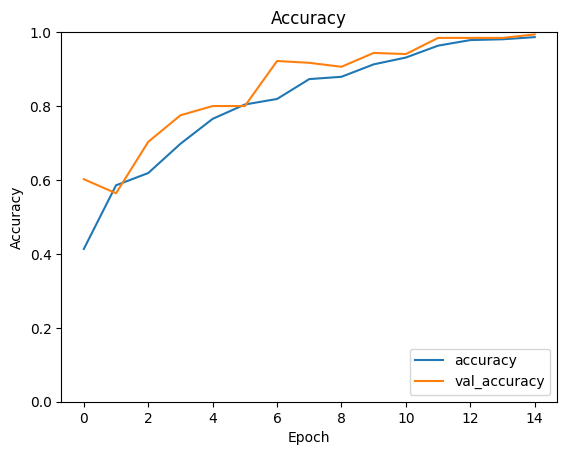

In [57]:
#grafico
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Accuracy')
plt.legend(loc='lower right')
plt.show()

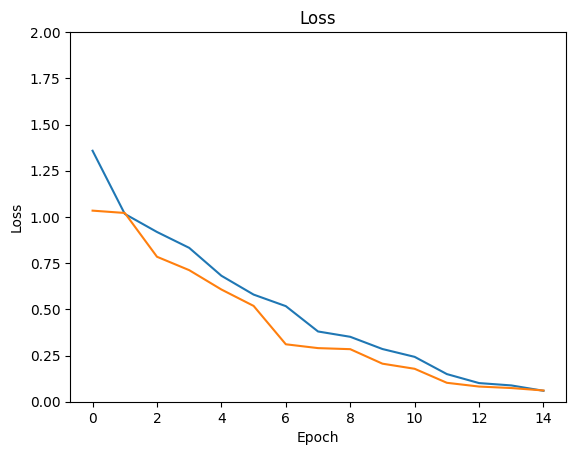

In [58]:
#grafico de la loss 
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.title('Loss')
plt.show()

## <span style="color:lightblue">Model 1 - Evaluation</span>

In [59]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_score, roc_curve

### Accuracy, Validation Accuracy, Loss, Validation Loss

In [60]:
def evaluate_model1(history, epochs, digits_round=2):
    acc = history.history['accuracy']
    acc = round(acc[epochs], digits_round)
    acc = str(acc)


    val_acc = history.history['val_accuracy']
    val_acc = round(val_acc[epochs], digits_round)
    val_acc = str(val_acc)

    loss = history.history['loss']
    loss = round(loss[epochs], digits_round)
    loss = str(loss)

    val_loss = history.history['val_loss']
    val_loss = round(val_loss[epochs], digits_round)
    val_loss = str(val_loss)

    print("Accuracy: " + acc)
    print("Validation Accuracy: " + val_acc)
    print("Loss: " + loss)
    print("Validation Loss: " + val_loss)

In [61]:
evaluate_model1(history, epoch-1)

Accuracy: 0.99
Validation Accuracy: 0.99
Loss: 0.06
Validation Loss: 0.06


In [62]:
X_test = X_test.reshape(-1, img_height, img_width, 3)

In [63]:
print(X_test.shape)  # Should output (352, 100, 100, 3)

(352, 224, 224, 3)


In [64]:
y_pred = modelo.predict(X_test)
y_pred

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


array([[8.56048136e-04, 9.98249054e-01, 2.23954212e-05, 2.40339050e-05,
        8.48448428e-04],
       [2.38241022e-03, 7.69759121e-04, 6.89900815e-01, 8.07651395e-06,
        3.06938976e-01],
       [5.74519345e-06, 7.64767321e-07, 9.99968767e-01, 2.63663069e-09,
        2.48106553e-05],
       ...,
       [8.44545837e-04, 5.47401651e-05, 2.84537762e-01, 1.24789690e-09,
        7.14562893e-01],
       [4.22978832e-04, 1.66922939e-04, 9.96656895e-01, 1.66408014e-07,
        2.75307801e-03],
       [5.45580033e-03, 1.14330454e-04, 9.91732001e-01, 5.30516964e-09,
        2.69787968e-03]], dtype=float32)

### Confusion Matrix

In [65]:
def confusion_matrix1(y_test, y_pred):
    # Check if y_pred is 1-dimensional or 2-dimensional
    if y_pred.ndim == 1:
        y_pred_class = y_pred
    else:
        y_pred_class = y_pred.argmax(axis=1)
    
    accuracy = accuracy_score(y_test, y_pred_class)
    print("Accuracy:", accuracy)

    cm = confusion_matrix(y_test, y_pred_class)

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(cm, annot=True, ax=ax)
    _ = plt.xlabel("Predicted")
    _ = plt.ylabel("Actual")

In [66]:
# Assuming y_test has shape (11, 32)
y_test = y_test.reshape(-1)

# Now y_test should have shape (352,)

In [67]:
X_test = X_test.reshape(-1, img_height, img_width, 3)
y_pred = modelo.predict(X_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Accuracy: 0.9886363636363636


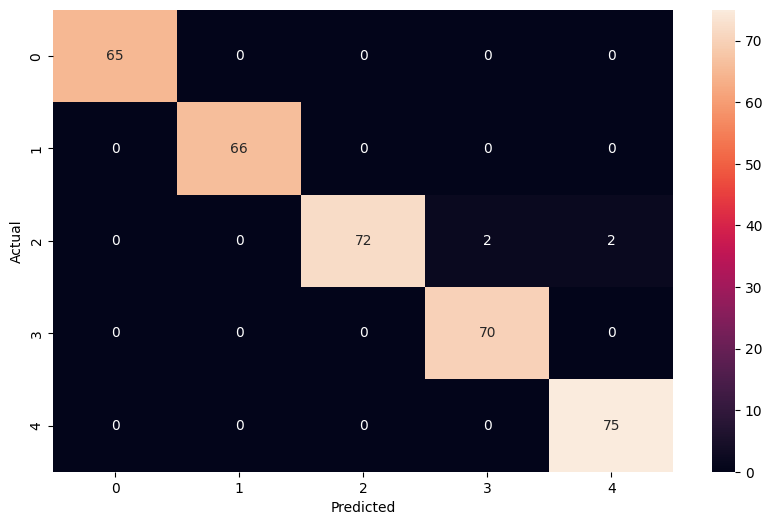

In [68]:
confusion_matrix1(y_test, y_pred)

In [69]:
from tensorflow import keras
from keras import utils
from tensorflow.keras.utils import plot_model

%pip install pydot



Note: you may need to restart the kernel to use updated packages.


In [70]:
# Plot the model architecture
plot_model(modelo, to_file='model_architecture.png', show_shapes=True, dpi=75)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


## <span style="color:lightblue">Model 1 - Save</span>

In [71]:
modelo.save('ModelSecuential.h5')

# <span style="color:gold">VGG16 - Model 2</span>

In [72]:
train_ds

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [39]:
num_classes = 5

def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=num_classes)
    return image, label

# Aplica la transformación al dataset
train_ds_one_hot = train_ds.map(one_hot_encode)
val_ds_one_hot = val_ds.map(one_hot_encode)
test_ds_one_hot = test_ds.map(one_hot_encode)


In [40]:
# Cargar VGG16 preentrenado sin la parte de clasificación
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas convolucionales preentrenadas
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Añadir nuevas capas completamente conectadas
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Para evitar sobreajuste
output = Dense(num_classes, activation='softmax')(x)  # Número de clases

# Crear el modelo final
modelo2 = Model(inputs=base_model.input, outputs=output)

In [ ]:
modelo2.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [ ]:
epoch2 = 4
history2 = modelo2.fit(
    train_ds_one_hot,
    validation_data=val_ds_one_hot,
    epochs=epoch2,
)

Epoch 1/4
30/30 ━━━━━━━━━━━━━━━━━━━━ 203s 7s/step - accuracy: 0.5380 - loss: 24.6763 - val_accuracy: 0.9250 - val_loss: 1.7558
Epoch 2/4
30/30 ━━━━━━━━━━━━━━━━━━━━ 232s 8s/step - accuracy: 0.8468 - loss: 3.9754 - val_accuracy: 0.9500 - val_loss: 0.4821
Epoch 3/4
30/30 ━━━━━━━━━━━━━━━━━━━━ 222s 7s/step - accuracy: 0.8658 - loss: 1.4911 - val_accuracy: 0.9654 - val_loss: 0.2533
Epoch 4/4
30/30 ━━━━━━━━━━━━━━━━━━━━ 214s 7s/step - accuracy: 0.8896 - loss: 0.9977 - val_accuracy: 0.9585 - val_loss: 0.2811


In [ ]:
#graficos 

def plot_metrics(history):
    # Accuracy
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.title('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

    # Loss
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 2])
    plt.title('Loss')
    plt.show()

plot_metrics(history2)

## <span style="color:lightblue">Model 2 - Evaluation</span>

### Accuracy, Validation Accuracy, Loss, Validation Loss

In [80]:
evaluate_model1(history2, epoch2-1)

Accuracy: 0.88
Validation Accuracy: 0.96
Loss: 1.02
Validation Loss: 0.28


### Confusion Matrix

Accuracy: 0.9886363636363636


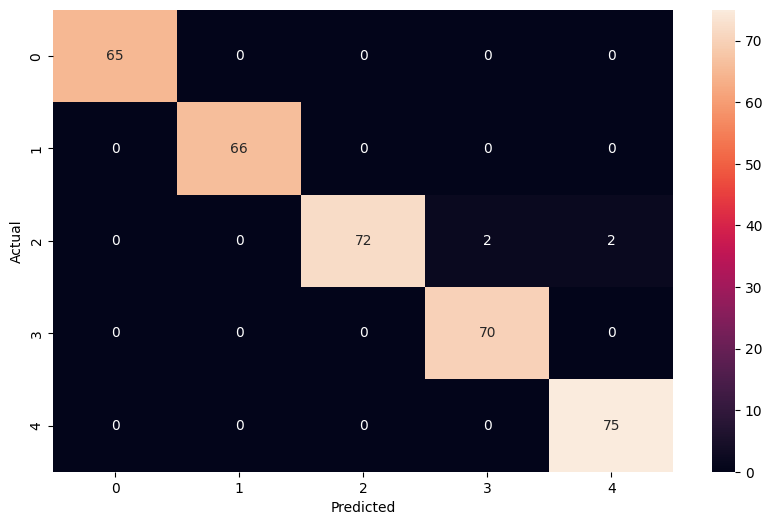

In [81]:
confusion_matrix1(y_test, y_pred)

## <span style="color:lightblue">Model 2 - Save</span>

In [ ]:
modelo2.save('VGG16_Model.h5')

# <span style="color:gold">VGG19 - Model 3</span>

## Creacion del modelo

## Compilación del modelo

## <span style="color:lightblue">Model 3 - Evaluation</span>

### Accuracy, Validation Accuracy, Loss, Validation Loss

### Confusion Matrix

## <span style="color:lightblue">Model 3 - Save</span>

# AleNet - Model 4

## Creacion del modelo

In [41]:
modelo4 = Sequential([
    Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D((3, 3), strides=2),

    Conv2D(256, (5, 5), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((3, 3), strides=2),

    Conv2D(384, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(384, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((3, 3), strides=2),

    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax'),
])



## Compilación del modelo

In [42]:
from tensorflow.keras.optimizers import SGD
modelo4.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [45]:
y_train = [y for _, y in train_ds_one_hot]
y_train = np.array(y_train)

In [48]:
#convertir las etiquetas a one-hot encoding
from tensorflow.keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train, num_classes=5) 
y_test = to_categorical(y_test, num_classes=5) 


## Entrenamiento del modelo

In [50]:
epoch4 = 5
history4 = modelo4.fit(
    train_ds_one_hot,
    validation_data=val_ds_one_hot,
    epochs=epoch4,
) 

Epoch 1/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.2844 - loss: 13.8586 - val_accuracy: 0.1937 - val_loss: 3607.2690
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 977ms/step - accuracy: 0.3932 - loss: 11.3952 - val_accuracy: 0.1656 - val_loss: 107.0707
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 923ms/step - accuracy: 0.3245 - loss: 5.2430 - val_accuracy: 0.1906 - val_loss: 33.0317
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 968ms/step - accuracy: 0.3975 - loss: 3.1179 - val_accuracy: 0.4344 - val_loss: 2.3263
Epoch 5/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.4558 - loss: 1.9889 - val_accuracy: 0.3875 - val_loss: 3.1848


## Evaluación del modelo

In [88]:
#evaluar el modelo

def evaluate_model1(history, epochs, digits_round=2):
    acc = history.history['accuracy']
    acc = round(acc[epochs], digits_round)
    acc = str(acc)

    val_acc = history.history['val_accuracy']
    val_acc = round(val_acc[epochs], digits_round)
    val_acc = str(val_acc)

    loss = history.history['loss']
    loss = round(loss[epochs], digits_round)
    loss = str(loss)

    val_loss = history.history['val_loss']
    val_loss = round(val_loss[epochs], digits_round)
    val_loss = str(val_loss)

    print("Accuracy: " + acc)
    print("Validation Accuracy: " + val_acc)
    print("Loss: " + loss)
    print("Validation Loss: " + val_loss)

# Assuming history4 and epoch4 are defined
evaluate_model1(history4, epoch4-1)




Accuracy: 0.47
Validation Accuracy: 0.39
Loss: 2.06
Validation Loss: 3.18


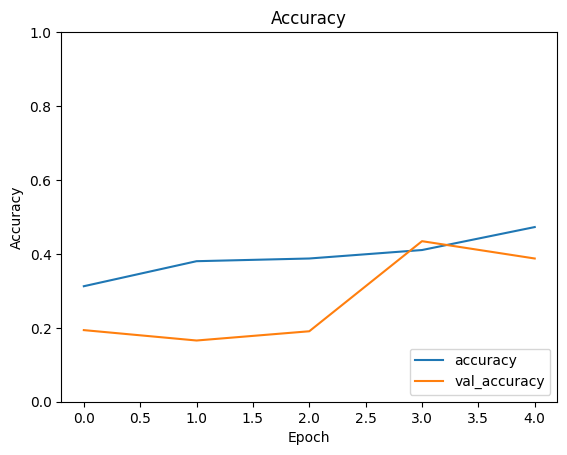

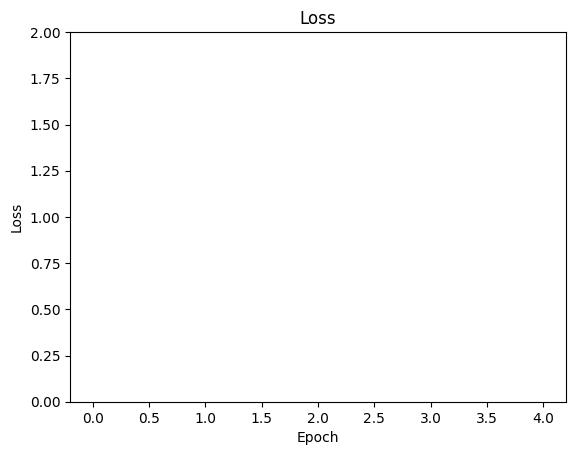

In [94]:
#graficos 

def plot_metrics(history):
    # Accuracy
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.title('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

    # plotear la loss del modelo
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 2])
    plt.title('Loss')
    plt.show()

plot_metrics(history4)

In [95]:
y_test = y_test[:352]

print("Shape of y_test:", y_test.shape)


Shape of y_test: (319,)


## Classification Report

## Confusion matrix

In [96]:
print("NaN values in y_pred:", np.isnan(y_pred).sum())

NaN values in y_pred: 0


In [97]:
y_pred = np.nan_to_num(y_pred, nan=-1)  # Replace NaN with -1 or any other appropriate value

In [98]:
print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)
print("y_test type:", type(y_test))
print("y_pred type:", type(y_pred))

y_test shape: (319,)
y_pred shape: (319,)
y_test type: <class 'numpy.ndarray'>
y_pred type: <class 'numpy.ndarray'>


In [99]:
if y_pred.ndim > 1:
    y_pred = y_pred.argmax(axis=1)

Shape of y_test: (319,)
Shape of y_pred: (319,)


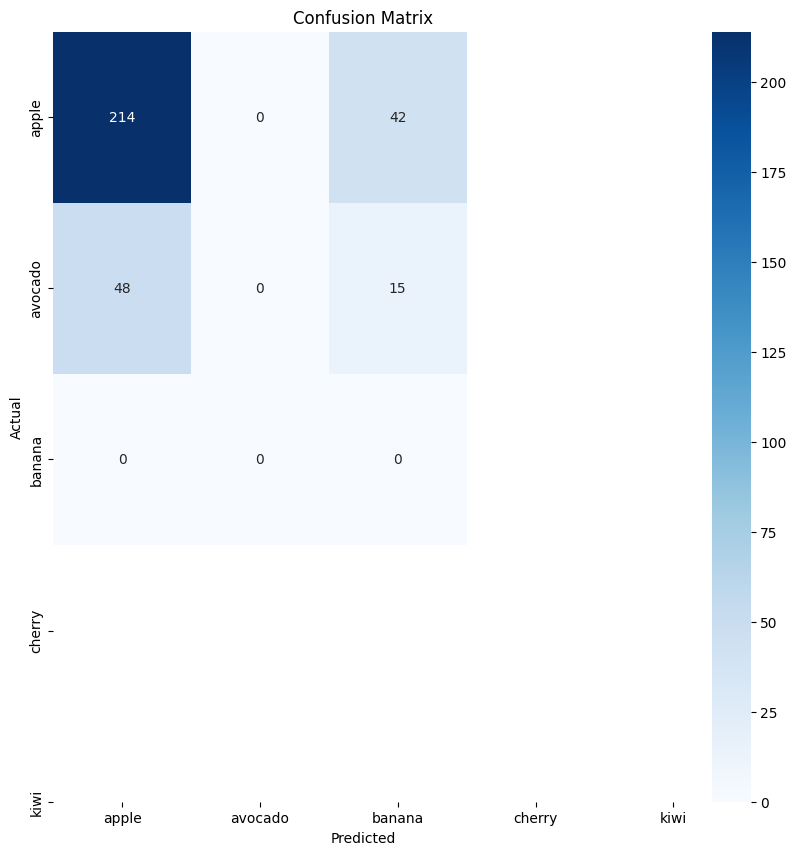

In [103]:
# matriz de confusión avaznada para una clasificacion multi-clase. por favor chequea  los shapes y corregilos en caso de que esten mal para poder hacer la confusion matrix

# que se vean las imagenes de las frutas, son 5. es un problema de clasificacion multiclase
labels = ["apple", "avocado", "banana", "cherry", "kiwi"]

def confusion_matrix4(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


y_pred = y_pred[:319] 
y_test = y_test[:319]

print("Shape of y_test:", y_test.shape) # Should output (319,)

print("Shape of y_pred:", y_pred.shape) # Should output (319,)

confusion_matrix4(y_test, y_pred)

  

###  el modelo no predice ciertas frutas porque no tiene suficientes datos para entrenar, por lo que no puede generalizar bien.

## Save model

In [ ]:
modelo4.save('Modelo4.h5')

# Modelo 6 - ResNet(Residual Network)

## Creación y compilación del modelo

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

data_dir = 'fruits'
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.4,  #40 para validación y test
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# 60%
para_entrenar = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

#20%
para_validar = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

#20%
para_test = ImageDataGenerator(rescale=1./255)

test_generator = para_test.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

#hacer un for que haga lo mismo que hice arriba, que lo hice 3 veces cuando en realidad se puede reemplazar con un for. 


modelo_base = ResNet50(weights='imagenet', include_top=False)



Found 962 images belonging to 5 classes.
Found 639 images belonging to 5 classes.
Found 0 images belonging to 5 classes.


In [10]:
from tensorflow.keras.optimizers import Adam
# Define the model
modelo6 = Sequential( [
    modelo_base,
    GlobalAveragePooling2D(), # evita el overfitting
    Dense(1024, activation='relu'),
    Dense(para_entrenar.num_classes, activation='softmax'), #agreagr Fine-tuning ABAJO
])

# congelo las capas de la red neuronal preentrenada
modelo_base.trainable = False
# # Congela las primeras capas (por ejemplo, las iniciales)
# for layer in modelo_base.layers[:100]:
#     layer.trainable = False

# Compile the model
modelo6.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
    )



In [12]:
# entrenamientro 

# Entrenamiento del modelo
history6 = modelo6.fit(
    para_entrenar,
    validation_data= para_validar,
    epochs=10 
)


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.2475 - loss: 1.8008 - val_accuracy: 0.3349 - val_loss: 1.9368
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.2776 - loss: 1.7514 - val_accuracy: 0.4038 - val_loss: 1.4528
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.3597 - loss: 1.4582 - val_accuracy: 0.3020 - val_loss: 1.5298
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.3107 - loss: 1.5314 - val_accuracy: 0.3099 - val_loss: 1.5830
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.3395 - loss: 1.5278 - val_accuracy: 0.3505 - val_loss: 1.5797
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.3333 - loss: 1.5344 - val_accuracy: 0.3881 - val_loss: 1.4712
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.3608 - loss: 1.4357 - val_accuracy: 0.3427 - val_loss: 1.5317
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.3204 - loss: 1.5074 - val_accuracy: 0.3646 - val_loss:

## Entrenamiento y evaluación del modelo

In [107]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorea la pérdida de validación
    patience=3,          # Detiene el entrenamiento si no mejora en 3 *epochs*
    restore_best_weights=True  # Restaura los mejores pesos del modelo
)

In [109]:
#evaluacion del modelo con: Accuracy, Presicion, Recall, F1 score, Validation accuracy, Validation loss, Confusion Matrix.

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_score, roc_curve

# Fine-tuning (Desbloquear algunas capas del modelo base)
modelo_base.trainable = True
for layer in modelo_base.layers[:100]:  # Congelar las primeras 100 capas
    layer.trainable = False

# Recompilación del modelo con fine-tuning
modelo6.compile(
    optimizer=Adam(learning_rate=1e-5),  # Learning rate bajo para evitar sobreajuste
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento adicional (fine-tuning) con capas desbloqueadas
history_fine6 = modelo6.fit(
    para_entrenar,
    validation_data=para_validar,
    epochs=50,
    callbacks=[early_stopping]  # Callback de Early Stopping
)



Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 151s 4s/step - accuracy: 0.4461 - loss: 1.3316 - val_accuracy: 0.2097 - val_loss: 2.5966
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 119s 4s/step - accuracy: 0.5199 - loss: 1.2090 - val_accuracy: 0.2567 - val_loss: 1.8734
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 126s 4s/step - accuracy: 0.4865 - loss: 1.2591 - val_accuracy: 0.3615 - val_loss: 1.4447
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.5141 - loss: 1.2105 - val_accuracy: 0.3756 - val_loss: 1.4501
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.5252 - loss: 1.1654 - val_accuracy: 0.4742 - val_loss: 1.2903
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 125s 4s/step - accuracy: 0.5108 - loss: 1.1716 - val_accuracy: 0.4476 - val_loss: 1.3045
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 130s 4s/step - accuracy: 0.5326 - loss: 1.1486 - val_accuracy: 0.4648 - val_loss: 1.2777
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 119s 4s/step - accuracy: 0.5544 - loss: 1.1164 - val_accuracy: 0.5133 - v

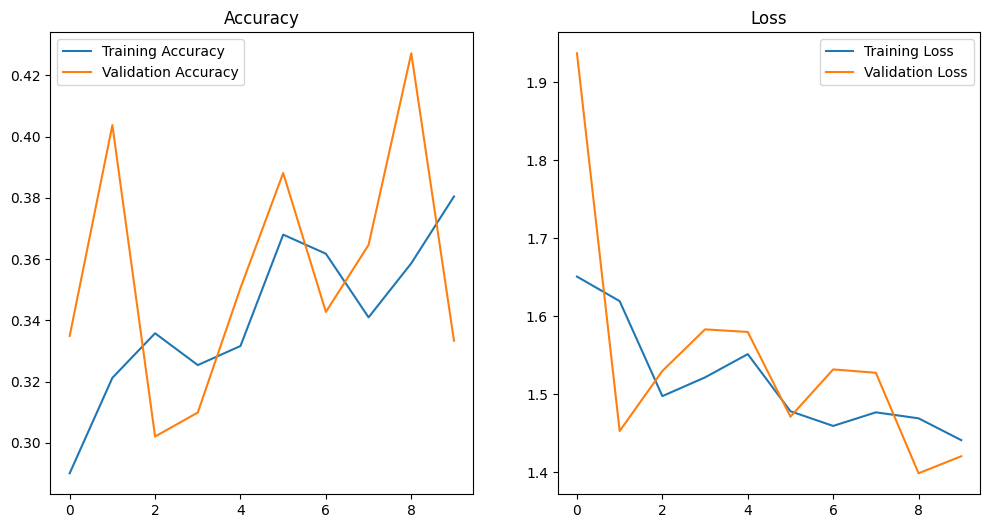

In [110]:
# grafico de la accuracy y loss del primer entrenamiento
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history6.history['accuracy'], label='Training Accuracy')
plt.plot(history6.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history6.history['loss'], label='Training Loss')
plt.plot(history6.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()



In [111]:
print(f"Number of test samples: {test_generator.samples}")


Number of test samples: 319


In [112]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 319 images belonging to 5 classes.


In [113]:
print(f"Number of test samples: {test_generator.samples}")

Number of test samples: 319


In [114]:
print(para_entrenar.class_indices)
print(para_entrenar.samples)


{'apple': 0, 'avocado': 1, 'banana': 2, 'cherry': 3, 'kiwi': 4}
962


In [ ]:
# Evaluación en datos de prueba después de fine-tuning
test_loss, test_acc = modelo6.evaluate(test_generator)
print(f"Test Accuracy (Fine-tuned): {test_acc}")
print(f"Test Loss (Fine-tuned): {test_loss}")

# Generación de métricas avanzadas
y_pred = modelo6.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes




10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5102 - loss: 1.1681
Test Accuracy (Fine-tuned): 0.5360501408576965
Test Loss (Fine-tuned): 1.1455259323120117
 1/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step

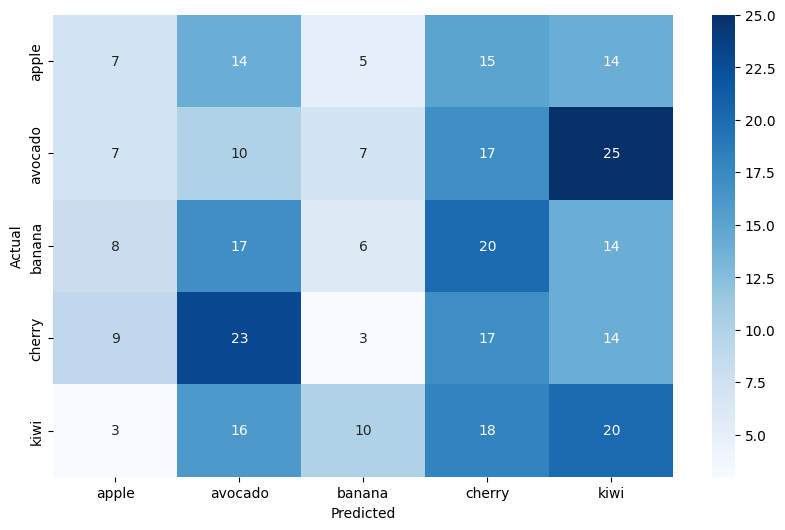

In [116]:
# confusion matrix AVANZADA

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes, figsize=(10, 6)):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plot_confusion_matrix(y_true, y_pred_classes, classes=test_generator.class_indices.keys())

In [117]:
# Classification Report

from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

       apple       0.21      0.13      0.16        55
     avocado       0.12      0.15      0.14        66
      banana       0.19      0.09      0.12        65
      cherry       0.20      0.26      0.22        66
        kiwi       0.23      0.30      0.26        67

    accuracy                           0.19       319
   macro avg       0.19      0.19      0.18       319
weighted avg       0.19      0.19      0.18       319



In [118]:
modelo6.save('Modelo6 - ResNet.h5')